<a href="https://colab.research.google.com/github/binodmathews93/AppliedMachineLearningCourse/blob/master/Applied_Machine_Learning_Homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Convert to a DataFrame.
import pandas as pd
from sklearn.datasets import fetch_openml

df = fetch_openml('credit-g', as_frame=True).frame
df.head(5)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


In [2]:
df.dtypes

checking_status           category
duration                   float64
credit_history            category
purpose                   category
credit_amount              float64
savings_status            category
employment                category
installment_commitment     float64
personal_status           category
other_parties             category
residence_since            float64
property_magnitude        category
age                        float64
other_payment_plans       category
housing                   category
existing_credits           float64
job                       category
num_dependents             float64
own_telephone             category
foreign_worker            category
class                     category
dtype: object

# **Features that are categorical and those that are Continuous**

Category - checking_status, credit_history , purpose , savings_status , employment , installment_commitment, personal_status , other_parties , residence_since , property_magnitude , other_payment_plans ,housing , existing_credits, job , num_dependents , own_telephone , foreign_worker , class

Continuous - duration, credit_amount , age

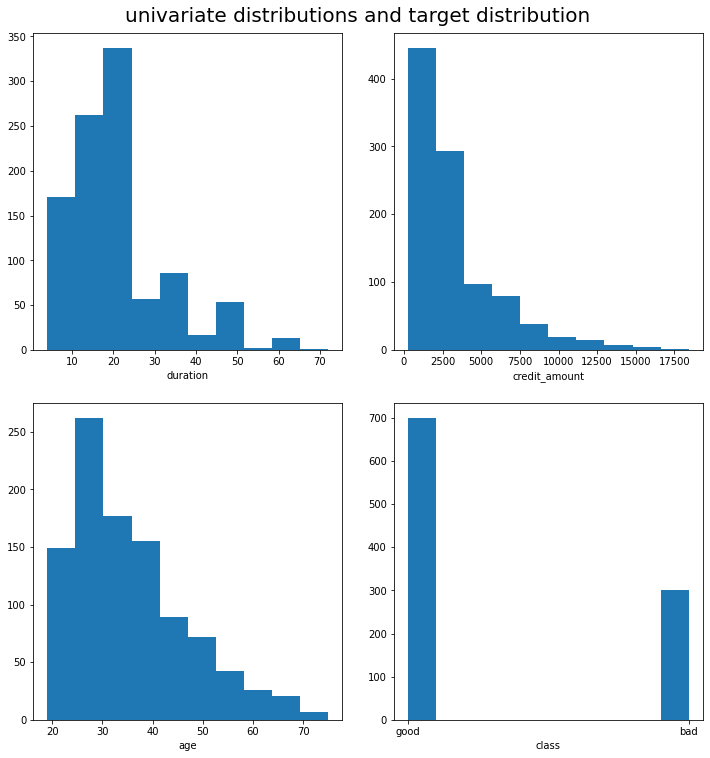

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
st = fig.suptitle("univariate distributions and target distribution", fontsize=20)

# Using columns that we need for this plot
nfeatures = df[['duration', 'credit_amount' , 'age']]
target = df['class']

# creating 4x4 grid
grid = plt.GridSpec(4, 4, hspace=0.4, wspace=0.4)

# creating the normal plots in grid 1 , 2 ,3 and 4
p1 = fig.add_subplot(grid[:2,:2])
p2 = fig.add_subplot(grid[:2,2:])
p3 = fig.add_subplot(grid[2:,:2])
p4 = fig.add_subplot(grid[2:,2:])

p1.hist(nfeatures['duration'])
p2.hist(nfeatures['credit_amount'])
p3.hist(nfeatures['age'])
p4.hist(target)

p1.set_xlabel('duration')
p2.set_xlabel('credit_amount')
p3.set_xlabel('age')
p4.set_xlabel('class')
# customizing to look neat
st.set_y(0.95)
fig.subplots_adjust(top=0.92)

In [4]:
# 1.3

from sklearn.model_selection import train_test_split

columns = [column for column  in df.columns if column != 'class']
X = df[columns]
y = df['class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#X_train , y_train , X_valid , y_valid = train_test_split(X,) 
# basic preprocessing on train sets
numeric_columns = ['duration','credit_amount','age']
categorical_columns = [column for column in columns if column not in numeric_columns]
temp = X_train[categorical_columns]
X_train_ohe = pd.concat([pd.get_dummies(temp),X_train[numeric_columns]],axis=1)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
lr = LogisticRegression(max_iter=1000)

cr = cross_val_score(lr,X_train_ohe,y_train)

print(cr)




[0.73125 0.76875 0.74375 0.6875  0.8125 ]


In [43]:
#1.4

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# define the data preparation for the categorical columns
t1 = [('cat', OneHotEncoder(), categorical_columns)]
col_transform = ColumnTransformer(transformers=t1)
# define the models
models = {'lr_model':LogisticRegression(max_iter=1000), 'lsvm_model':LinearSVC(dual=True,max_iter=2500) , 'knn_model':KNeighborsClassifier()}

for name,model in models.items():
  # define the data preparation and modeling pipeline
  pipeline = Pipeline(steps=[('prep',col_transform), ('m', model)])
  # define the model cross-validation configuration
  #cv = KFold(n_splits=10, shuffle=True, random_state=1)
  # evaluate the pipeline using cross validation and calculate MAE
  score = cross_val_score(pipeline, X_train, y_train)
  print(name ,score.mean())

# define the data preparation for the categorical columns and numeric columns
t2 = [('cat', OneHotEncoder(), categorical_columns), ('num', StandardScaler(), numeric_columns)]
col_transform = ColumnTransformer(transformers=t2)
# try with new column transformer
for name,model in models.items():
  # define the data preparation and modeling pipeline
  pipeline = Pipeline(steps=[('prep',col_transform), ('m', model)])
  # define the model cross-validation configuration
  #cv = KFold(n_splits=10, shuffle=True, random_state=1)
  # evaluate the pipeline using cross validation and calculate MAE
  score = cross_val_score(pipeline, X_train, y_train)
  print(name ,score.mean())

lr_model 0.7437499999999999
lsvm_model 0.735
knn_model 0.7137499999999999
lr_model 0.7425
lsvm_model 0.74
knn_model 0.7387499999999999


lr_model {'m__C': 0.1}
lr_model 0.745
lsvm_model {'m__C': 0.01}
lsvm_model 0.735
knn_model {'m__n_neighbors': 10}
knn_model 0.715


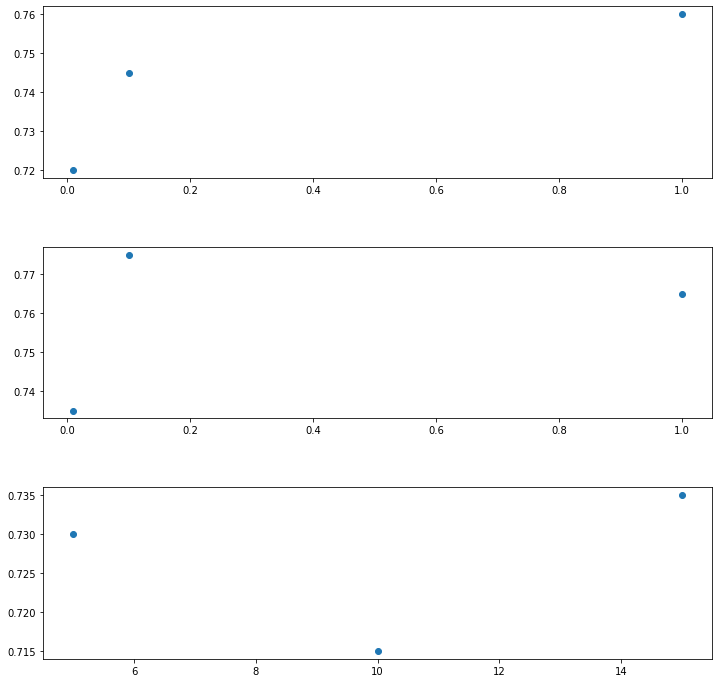

In [53]:
#1.5

from sklearn.model_selection import GridSearchCV

# 'prep__num__with_mean': [True, False],
# 'prep__num__with_std': [True, False],
param_grid = {
    'm__C': [0.1, 1.0 , 0.01],
    }

param_grid_knn = {
    'm__n_neighbors': [5, 10 , 15],
    }

for name,model in models.items():
  # define the data preparation and modeling pipeline
  pipeline = Pipeline(steps=[('prep',col_transform), ('m', model)])
  # define the model cross-validation configuration
  #cv = KFold(n_splits=10, shuffle=True, random_state=1)
  # evaluate the pipeline using cross validation and calculate MAE
  if name == 'knn_model':
      grid_clf = GridSearchCV(pipeline, param_grid_knn, cv=10)
  else:
      grid_clf = GridSearchCV(pipeline, param_grid, cv=10)
  grid_clf.fit(X_train, y_train)
  print(name,grid_clf.best_params_)
  print(name, grid_clf.best_estimator_.score(X_test, y_test))

from sklearn.metrics import accuracy_score
lr_array = []
lr_c = [0.01,0.1,1]

for c in lr_c:
  pipeline = Pipeline(steps=[('prep',col_transform), ('m', LogisticRegression(max_iter=1000, C=c))])
  pipeline.fit(X_train,y_train)
  y_hat = pipeline.predict(X_test)
  lr_array.append(accuracy_score(y_test,y_hat))


lsvm_array = []
lsvm_c = [0.01,0.1,1]

for c in lsvm_c:
  pipeline = Pipeline(steps=[('prep',col_transform), ('m', LinearSVC(dual=True,max_iter=2500,C=c))])
  pipeline.fit(X_train,y_train)
  y_hat = pipeline.predict(X_test)
  lsvm_array.append(accuracy_score(y_test,y_hat))


knn_array = []
knn_n = [5,10,15]

for n in knn_n:
  pipeline = Pipeline(steps=[('prep',col_transform), ('m', KNeighborsClassifier(n_neighbors=n))])
  pipeline.fit(X_train,y_train)
  y_hat = pipeline.predict(X_test)
  knn_array.append(accuracy_score(y_test,y_hat))

fig = plt.figure(figsize=(12, 12))
# creating 3x1 grid
grid = plt.GridSpec(3, 1, hspace=0.4, wspace=0.4)

# creating the normal plots in grid 1 , 2 ,3
p1 = fig.add_subplot(grid[0,:])
p2 = fig.add_subplot(grid[1,:])
p3 = fig.add_subplot(grid[2,:])

p1.scatter(lr_c,lr_array)
p2.scatter(lsvm_c,lsvm_array)
p3.scatter(knn_n,knn_array)
